*This notebook was created by Sergey Tomin (sergey.tomin@desy.de). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). May 2020.*

### Appendix: some useful OCELOT functions

This notebook was created to show those or other small functions that may be useful for accelerator physicists.

In [1]:
import sys
sys.path.append("/Users/tomins/Nextcloud/DESY/repository/ocelot")
from ocelot import *

initializing ocelot...


### Aperture
Suppose you have a simple (and imposible) missaligned dump beam line. 
And you want to know the best corrector setting to get 100% transmission. 

We are goring to explor the transmission in horizontal only. 

#### Lattice 

In [2]:
# import modules
import copy
import pandas as pd
import seaborn as sbn
import time
import matplotlib.pyplot as plt


d = Drift(l=1)

# horizontal correctors
c1 = Hcor()
c2 = Hcor()

# Sextupoles
sf = Sextupole(l=0.2, k2=3000)
sf.dx, sf.dy = 1e-3, -1e-3

sd = Sextupole(l=0.2, k2=-3000)
sd.dx, sd.dy = 1e-3, -1e-3


# Quadrupoles with transversal offsets
qf = Quadrupole(l=0.2, k1=1, k2=20)
qf.dx, qf.dy = 1e-3, -1e-3

qd = Quadrupole(l=0.2, k1=-1, k2=-20)
qd.dx, qd.dy = -1e-3, 1e-3

# Collimators
ap1 = Aperture(xmax=5e-3, dx=-1e-3)
ap2 = Aperture(xmax=5e-3, dx=1e-3)
# BPMs
m1 = Monitor()
m2 = Monitor()

cell = (d, c1, d, sf, d, qf, d, ap1, d, m1, d, c2, d, sd, d, qd, d, ap2, d, m2, d,)

lat = MagneticLattice(cell, method=MethodTM({"global": SecondTM}))

Create ParticleArray and Navigator objects

In [3]:
p_array_init = generate_parray(sigma_x=1e-3, sigma_px=5e-5, sigma_y=1e-5, sigma_py=1e-6, 
                               nparticles=20000, charge=1e-09, energy=1.)

correctors = [c1, c2]



#### function to calculate transmission through the lattice

In [4]:
def transmission(lat, navi, correctors, kicks):
    for i, kick in enumerate(kicks):
        correctors[i].angle = kick
    
    lat.update_transfer_maps()
    
    # reset position of the Navigator 
    navi.reset_position()
    
    p_array = copy.deepcopy(p_array_init)
    tws_tack, p_array = track(lat, p_array, navi, calc_tws=False, print_progress=False)
    trans = p_array.n / p_array_init.n
    return trans


def scan(cor1_range, cor2_range):
    trans_response = np.zeros((len(cor2_range), len(cor1_range)))

    for i, a2 in enumerate(A2):
        print(f"{i} of {len(A2)}", end="\r")
        for j, a1 in enumerate(A1):
            kicks = [a1, a2]
            trans_response[i, j] = transmission(lat, navi, correctors, kicks)
    
    return trans_response

### Scan with two correctors. Apertures are NOT activated. 
Here we expect 100% transmission for any corrector settings.

 exec n_tracks=612:  21.513805150985718 s


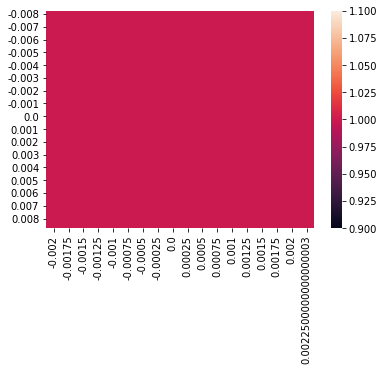

In [5]:
navi = Navigator(lat)

A1 = np.arange(-2, 2.5, 0.25)*1e-3
A2 = np.arange(-8, 9., 0.5)*1e-3

start = time.time()

trans_response = scan(A1, A2)

print(f" exec n_tracks={len(A2) * len(A1)}:  {time.time() - start} s")
df = pd.DataFrame(trans_response, index=A2, columns=A1)
sbn.heatmap(df)
plt.show()

### Scan with two correctors. Apertures are activated. 

 exec n_tracks=612:  20.26652216911316 s


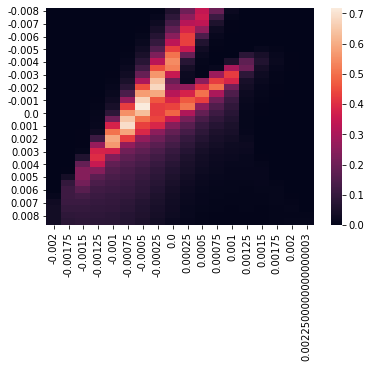

In [6]:
navi = Navigator(lat)

# activate apertures
navi.activate_apertures()

# activate apertures starting from element "start" up to element "stop"
# navi.activate_apertures(start=None, stop=m1)

start = time.time()

trans_response = scan(A1, A2)

print(f" exec n_tracks={len(A2) * len(A1)}:  {time.time() - start} s")
df = pd.DataFrame(trans_response, index=A2, columns=A1)
sbn.heatmap(df)
plt.show()

## To be continued ... 